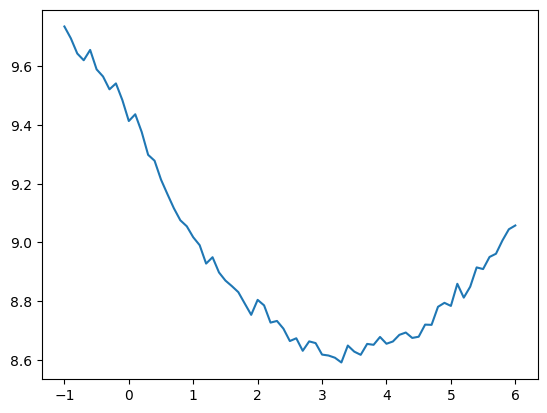

In [16]:
import random
import matplotlib.pyplot as plt

def calcResidual(fuel, ox):
    """Take in real loaded fuel and ox masses, and determine the residual propellant that will be left"""
    if fuel > 0.5*ox:
        return fuel - 0.5*ox
    else:
        return ox - 2.0*fuel
    
def runOneSim(fuelBiasLoad, uncertaintySigma):
    """Do a single draw of the actual propellant load given the desired bias (positive for extra fuel,
    negative for extra ox), and the standard deviation of the mass measurement error for each prop type"""
    fuelDraw = random.gauss(1000, uncertaintySigma)
    oxDraw = random.gauss(2000, uncertaintySigma)
    if fuelBiasLoad >= 0:
        fuelDraw += fuelBiasLoad
    else:
        oxDraw -= fuelBiasLoad
    return (fuelDraw, oxDraw)

def runMonteCarlo(fuelBiasLoad, numRuns, uncertaintySigma=7.07):
    """Do a number of runs with a given fuel bias load and return the average propellant residual
    over all the runs"""
    totalResidual = 0.0
    for i in range(numRuns):
        fuelDraw, oxDraw = runOneSim(fuelBiasLoad, uncertaintySigma)
        totalResidual += calcResidual(fuelDraw, oxDraw)
    return totalResidual / float(numRuns)

def runSimsAndPlot():
    """get an idea of the fuel bias value that minimizes mean propellant residual mass"""
    currentBias = -1.0
    biases = []
    avgResiduals = []
    while currentBias <= 6:
        biases.append(currentBias)
        avgResiduals.append(runMonteCarlo(currentBias, 100000))
        currentBias += 0.1
    plt.plot(biases, avgResiduals)
    plt.show()

runSimsAndPlot()


In [35]:
import numpy as np
from scipy import integrate
from scipy import optimize

def residual(o2f, fuel_bias, ox_err, fuel_err):
    """Take in the oxidizer to fuel mass consumption ratio o2f,
    the intended additional fuel load beyond parity with loaded ox in kg fuel_bias,
    the difference of real - estimated fuel load fuel_err, and
    the difference of real - estimated oxidizer load ox_err.
    Calculate the residual propellant mass in kg after one of the proellant types
    runs out"""
    comparison_criterion = fuel_bias + fuel_err - ox_err / o2f
    if comparison_criterion >= 0:
        # there is excess fuel
        return comparison_criterion
    else: # excess oxidizer
        return o2f * (-comparison_criterion)

def getExpResidualIntegrand(o2f, fuel_bias, fuel_sigma, ox_sigma):
    """For given values of O/F ratio and intended fuel bias load, return the function
    to calculate the residual propellant, as a functio of only the random variables 
    fuel_err and ox_err"""
    sqrt2pi = np.sqrt(2*np.pi)
    return lambda ox_err, fuel_err: residual(o2f, fuel_bias, ox_err, fuel_err) *\
    1.0/(fuel_sigma*sqrt2pi)*np.exp(-0.5*(fuel_err/fuel_sigma)**2) *\
    1.0/(ox_sigma*sqrt2pi)*np.exp(-0.5*(ox_err/ox_sigma)**2)

def getExpectedResidual(o2f, fuel_bias, fuel_sigma, ox_sigma, integ_lim=1e3):
    """f"""
    func = getExpResidualIntegrand(o2f, fuel_bias, fuel_sigma, ox_sigma)
    part1 = integrate.dblquad(func,-integ_lim,integ_lim,lambda ox_err: -integ_lim,lambda ox_err: ox_err/o2f - fuel_bias)[0]
    part2 = integrate.dblquad(func,-integ_lim,integ_lim,lambda ox_err: ox_err/o2f - fuel_bias,lambda ox_err: integ_lim)[0]
    return part1+part2

def minimizeResidual(o2f, fuel_sigma, ox_sigma):
    cost = lambda fuel_bias: getExpectedResidual(o2f, fuel_bias, fuel_sigma, ox_sigma, 6*(fuel_sigma+ox_sigma))
    return optimize.minimize(cost, fuel_sigma/o2f, bounds=optimize.Bounds(lb=0))

o2f = 2
fuel_sigma = 7.07
ox_sigma = 7.07
print(minimizeResidual(o2f, fuel_sigma, ox_sigma))



  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 9.472835940467625
        x: [ 5.027e+00]
      nit: 5
      jac: [ 1.421e-06]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
